In [1]:
import sys
sys.path.append("E:/university/Year 5 Spring/FYT/code/multi_modal_ser")
from utils.const import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import Audio

In [2]:
# Define const path
SPEC_PATH = "E:/datasets/preprocessed/spectrogram"
AST_PATH = os.path.join(SPEC_PATH, "ast")
LIBROSA_PATH = os.path.join(SPEC_PATH, "librosa")
INV_AST_PATH = os.path.join(SPEC_PATH, "inv_ast")
INV_LIBROSA_PATH = os.path.join(SPEC_PATH, "inv_librosa")
RAW_PATH = os.path.join(SPEC_PATH, "raw")

In [3]:
MAX_LEN = 1024
NORM_SPEC = False
HOP_LENGTH = None

### extract audio data

In [4]:
video_rate = 30

from scipy.io import wavfile
import time

spectrogramPATH = 'E:/datasets/preprocessed/spectrogram'
audio_data_list = []

now = time.time()
for ses in range(1, 6):
    extractionmapPATH = 'E:/datasets/preprocessed/extractionmap/cut_extractionmap' + \
        str(ses)+'.xlsx'
    xl = pd.ExcelFile(extractionmapPATH)
    sheets = xl.sheet_names
    spectrogramPATH = spectrogramPATH+'/Session'+str(ses)+'/'
    wavPATH = 'E:/datasets/IEMOCAP_full_release.tar/IEMOCAP_full_release/IEMOCAP_full_release/Session' + \
        str(ses)+'/dialog/wav/'
    for sheet in sheets:
        fileNAME = sheet+'.wav'
        spectrogramPATH = spectrogramPATH+fileNAME+'/'
        audio_rate, data = wavfile.read(wavPATH+fileNAME)
        sheet_df = xl.parse(sheet)
        iframe = np.array(sheet_df['iframe'])
        fframe = np.array(sheet_df['fframe'])
        smp_ids = np.array(sheet_df['smp_id'])
        
        idx = 1
        for idx in range(len(smp_ids)):
            multiframedata = data[iframe[idx]:(fframe[idx]+1)]
            multiframedata = multiframedata.astype('float64').mean(axis=1)
            audio_data_list.append({
                "id": smp_ids[idx],
                "data": multiframedata,
            })
print("Extracting Audios: ", time.time()-now)

Extracting Audios:  19.252883672714233


In [5]:
print(len(audio_data_list))
audio_data_list[0]

10039


{'id': 'Ses01F_impro01_F000',
 'data': array([-130. , -176.5, -263. , ..., -124. ,  -98. ,  -47. ])}

### Define util funcs

In [6]:
# Noticed that the spectrograms here are all before normalization and logged
import librosa
from transformers import ASTFeatureExtractor, ASTModel
from scipy.io.wavfile import write

processor = ASTFeatureExtractor(max_length=MAX_LEN, do_normalize=NORM_SPEC)

def gen_librosa_spec(fn, raw_audio):
    mel = librosa.feature.melspectrogram(y=raw_audio, sr=audio_rate, hop_length=256, n_mels=80)
    mel_spec = np.log(mel)
    np.save(os.path.join(LIBROSA_PATH, fn),mel_spec)
    return mel_spec
    
def gen_ast_spec(fn, raw_audio):
    inputs = processor(raw_audio, sampling_rate=audio_rate, return_tensors="np")
    ast_spec = inputs["input_values"][0].T
    np.save(os.path.join(AST_PATH, fn),ast_spec)
    return ast_spec
    
def save_inv(fn, mel_spec, method=None):
    stft = librosa.feature.inverse.mel_to_stft(np.exp(mel_spec))
    inv_audio = librosa.griffinlim(stft)
    if method is None:
        raise Exception
    inv_save_path = os.path.join(SPEC_PATH, "inv_{}".format(method))
    write(os.path.join(inv_save_path, fn+".wav"), audio_rate, inv_audio.astype("int16"))
    return inv_audio

def save_raw(fn, raw_audio):
    write(os.path.join(RAW_PATH, fn+".wav"), audio_rate, raw_audio.astype("int16"))
    return raw_audio

# AST can be batched?
# AST takes infinite
def process_librosa(data_dict, save_inv_audio=False):
    fn = data_dict["id"]
    raw_audio = data_dict["data"]
    now = time.time()
    raw = save_raw(fn, raw_audio)
    print("Save Raw:", time.time() - now)
    now = time.time()
    
    librosa_spec = gen_librosa_spec(fn, raw_audio)
    print("Gen Spec:", time.time() - now)
    now = time.time()
    if save_inv_audio:
        inv_librosa = save_inv(fn, librosa_spec, "librosa")
        print("Save Inv:", time.time() - now)
        now = time.time()
        return raw, inv_librosa, librosa_spec
    else:
        return raw, librosa_spec

In [7]:
raw, inv_librosa, librosa_spec = process_librosa(audio_data_list[0], save_inv_audio=True)

Save Raw: 0.005003213882446289
Gen Spec: 4.9940924644470215
Save Inv: 2.2004897594451904


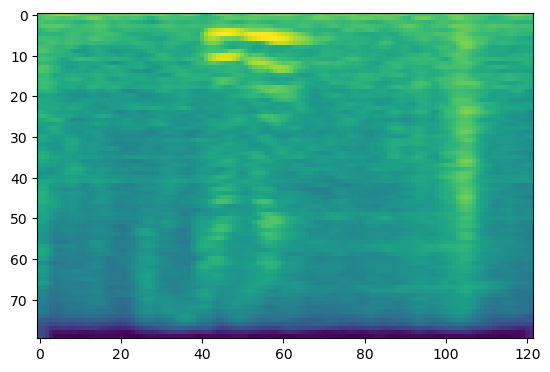

In [8]:
plt.imshow(librosa_spec)

In [9]:
Audio(raw, rate=audio_rate)

In [10]:
Audio(inv_librosa, rate=audio_rate)

### Pool librosa

The inversion takes much longer than generating the spectrogram

In [11]:
for audio_data in audio_data_list:
    process_librosa(audio_data)

Save Raw: 0.0010004043579101562
Gen Spec: 0.007999420166015625
Save Raw: 0.0009975433349609375
Gen Spec: 0.013000965118408203
Save Raw: 0.0010004043579101562
Gen Spec: 0.007000923156738281
Save Raw: 0.0020008087158203125
Gen Spec: 0.01215982437133789
Save Raw: 0.0
Gen Spec: 0.011996030807495117
Save Raw: 0.0
Gen Spec: 0.007999897003173828
Save Raw: 0.0
Gen Spec: 0.007996082305908203
Save Raw: 0.0
Gen Spec: 0.012000083923339844
Save Raw: 0.0
Gen Spec: 0.016000032424926758
Save Raw: 0.003999948501586914
Gen Spec: 0.012000083923339844
Save Raw: 0.0
Gen Spec: 0.011999845504760742
Save Raw: 0.0
Gen Spec: 0.020053625106811523
Save Raw: 0.0019998550415039062
Gen Spec: 0.0119171142578125
Save Raw: 0.0
Gen Spec: 0.015998363494873047
Save Raw: 0.003998756408691406
Gen Spec: 0.012000322341918945
Save Raw: 0.003999948501586914
Gen Spec: 0.015999794006347656
Save Raw: 0.004000186920166016
Gen Spec: 0.00800013542175293
Save Raw: 0.0
Gen Spec: 0.01199960708618164
Save Raw: 0.0039997100830078125
Gen S

Gen Spec: 0.01027226448059082
Save Raw: 0.0020074844360351562
Gen Spec: 0.017999649047851562
Save Raw: 0.001999378204345703
Gen Spec: 0.017000913619995117
Save Raw: 0.0030133724212646484
Gen Spec: 0.02498793601989746
Save Raw: 0.0009987354278564453
Gen Spec: 0.0060007572174072266
Save Raw: 0.00099945068359375
Gen Spec: 0.007000923156738281
Save Raw: 0.0030007362365722656
Gen Spec: 0.025999069213867188
Save Raw: 0.0050013065338134766
Gen Spec: 0.03599905967712402
Save Raw: 0.001998424530029297
Gen Spec: 0.016000032424926758
Save Raw: 0.0020012855529785156
Gen Spec: 0.010000228881835938
Save Raw: 0.0019974708557128906
Gen Spec: 0.008002281188964844
Save Raw: 0.003001689910888672
Gen Spec: 0.014999151229858398
Save Raw: 0.001999378204345703
Gen Spec: 0.012997627258300781
Save Raw: 0.0020003318786621094
Gen Spec: 0.009002685546875
Save Raw: 0.0019974708557128906
Gen Spec: 0.007999420166015625
Save Raw: 0.002001523971557617
Gen Spec: 0.009999752044677734
Save Raw: 0.001998424530029297
Gen S

Gen Spec: 0.04927492141723633
Save Raw: 0.0020003318786621094
Gen Spec: 0.015009880065917969
Save Raw: 0.0009899139404296875
Gen Spec: 0.004998922348022461
Save Raw: 0.002002716064453125
Gen Spec: 0.014998197555541992
Save Raw: 0.002998828887939453
Gen Spec: 0.017999649047851562
Save Raw: 0.007507801055908203
Gen Spec: 0.04300189018249512
Save Raw: 0.0019979476928710938
Gen Spec: 0.0040950775146484375
Save Raw: 0.004000663757324219
Gen Spec: 0.009672403335571289
Save Raw: 0.003006458282470703
Gen Spec: 0.021134614944458008
Save Raw: 0.0031414031982421875
Gen Spec: 0.01591777801513672
Save Raw: 0.008043766021728516
Gen Spec: 0.09987592697143555
Save Raw: 0.0020024776458740234
Gen Spec: 0.008997678756713867
Save Raw: 0.0009996891021728516
Gen Spec: 0.010001897811889648
Save Raw: 0.002997875213623047
Gen Spec: 0.02299952507019043
Save Raw: 0.003999948501586914
Gen Spec: 0.017000198364257812
Save Raw: 0.0030012130737304688
Gen Spec: 0.01599884033203125
Save Raw: 0.0030019283294677734
Gen S

Gen Spec: 0.012999534606933594
Save Raw: 0.0019989013671875
Gen Spec: 0.01699972152709961
Save Raw: 0.001999378204345703
Gen Spec: 0.019000768661499023
Save Raw: 0.0019986629486083984
Gen Spec: 0.02300119400024414
Save Raw: 0.004004478454589844
Gen Spec: 0.016154050827026367
Save Raw: 0.0
Gen Spec: 0.007998943328857422
Save Raw: 0.004019260406494141
Gen Spec: 0.007979631423950195
Save Raw: 0.0
Gen Spec: 0.00802159309387207
Save Raw: 0.0021135807037353516
Gen Spec: 0.003923654556274414
Save Raw: 0.004000186920166016
Gen Spec: 0.00999760627746582
Save Raw: 0.002198934555053711
Gen Spec: 0.004014492034912109
Save Raw: 0.003963947296142578
Gen Spec: 0.014323711395263672
Save Raw: 0.0
Gen Spec: 0.007966041564941406
Save Raw: 0.003996610641479492
Gen Spec: 0.023256778717041016
Save Raw: 0.0009996891021728516
Gen Spec: 0.008002042770385742
Save Raw: 0.003996849060058594
Gen Spec: 0.03299999237060547
Save Raw: 0.001999378204345703
Gen Spec: 0.013000726699829102
Save Raw: 0.003999471664428711
G

Gen Spec: 0.031070947647094727
Save Raw: 0.00600123405456543
Gen Spec: 0.06099748611450195
Save Raw: 0.002000570297241211
Gen Spec: 0.01399993896484375
Save Raw: 0.0030007362365722656
Gen Spec: 0.02500009536743164
Save Raw: 0.0009996891021728516
Gen Spec: 0.006000041961669922
Save Raw: 0.0010004043579101562
Gen Spec: 0.00600123405456543
Save Raw: 0.0039975643157958984
Gen Spec: 0.030002117156982422
Save Raw: 0.003000020980834961
Gen Spec: 0.017078161239624023
Save Raw: 0.0
Gen Spec: 0.01006627082824707
Save Raw: 0.0010004043579101562
Gen Spec: 0.0049991607666015625
Save Raw: 0.001001119613647461
Gen Spec: 0.004998922348022461
Save Raw: 0.0030007362365722656
Gen Spec: 0.02400040626525879
Save Raw: 0.0030007362365722656
Gen Spec: 0.01899886131286621
Save Raw: 0.004999399185180664
Gen Spec: 0.034003496170043945
Save Raw: 0.0009982585906982422
Gen Spec: 0.00800013542175293
Save Raw: 0.002000570297241211
Gen Spec: 0.00999903678894043
Save Raw: 0.001998424530029297
Gen Spec: 0.01600098609924

Gen Spec: 0.01300048828125
Save Raw: 0.002001523971557617
Gen Spec: 0.008996725082397461
Save Raw: 0.004001140594482422
Gen Spec: 0.02899909019470215
Save Raw: 0.0010006427764892578
Gen Spec: 0.010999679565429688
Save Raw: 0.001999378204345703
Gen Spec: 0.013000011444091797
Save Raw: 0.0010006427764892578
Gen Spec: 0.0059986114501953125
Save Raw: 0.003000974655151367
Gen Spec: 0.020999908447265625
Save Raw: 0.0020008087158203125
Gen Spec: 0.014999151229858398
Save Raw: 0.0019996166229248047
Gen Spec: 0.007094621658325195
Save Raw: 0.003984689712524414
Gen Spec: 0.010978221893310547
Save Raw: 0.003000020980834961
Gen Spec: 0.014999628067016602
Save Raw: 0.0009999275207519531
Gen Spec: 0.00800180435180664
Save Raw: 0.0019989013671875
Gen Spec: 0.00800013542175293
Save Raw: 0.0020008087158203125
Gen Spec: 0.014997720718383789
Save Raw: 0.002003192901611328
Gen Spec: 0.009998083114624023
Save Raw: 0.0019998550415039062
Gen Spec: 0.012000799179077148
Save Raw: 0.0019989013671875
Gen Spec: 0

Gen Spec: 0.017363309860229492
Save Raw: 0.0010020732879638672
Gen Spec: 0.00799703598022461
Save Raw: 0.0010023117065429688
Gen Spec: 0.009659528732299805
Save Raw: 0.0015308856964111328
Gen Spec: 0.006039142608642578
Save Raw: 0.0
Gen Spec: 0.008075952529907227
Save Raw: 0.003972291946411133
Gen Spec: 0.003996133804321289
Save Raw: 0.0
Gen Spec: 0.003999948501586914
Save Raw: 0.004000186920166016
Gen Spec: 0.006551265716552734
Save Raw: 0.0039899349212646484
Gen Spec: 0.003999948501586914
Save Raw: 0.003999948501586914
Gen Spec: 0.01600050926208496
Save Raw: 0.0
Gen Spec: 0.008003711700439453
Save Raw: 0.003998517990112305
Gen Spec: 0.007997274398803711
Save Raw: 0.0
Gen Spec: 0.003999948501586914
Save Raw: 0.003999948501586914
Gen Spec: 0.01600027084350586
Save Raw: 0.0
Gen Spec: 0.03160905838012695
Save Raw: 0.0020017623901367188
Gen Spec: 0.010266542434692383
Save Raw: 0.0019986629486083984
Gen Spec: 0.012000322341918945
Save Raw: 0.002000093460083008
Gen Spec: 0.01100039482116699

Gen Spec: 0.03699755668640137
Save Raw: 0.0019998550415039062
Gen Spec: 0.010001659393310547
Save Raw: 0.006000518798828125
Gen Spec: 0.03799867630004883
Save Raw: 0.0019991397857666016
Gen Spec: 0.009011507034301758
Save Raw: 0.0
Gen Spec: 0.011997699737548828
Save Raw: 0.0
Gen Spec: 0.0160062313079834
Save Raw: 0.0031173229217529297
Gen Spec: 0.004001617431640625
Save Raw: 0.003998517990112305
Gen Spec: 0.008018255233764648
Save Raw: 0.004001140594482422
Gen Spec: 0.007994651794433594
Save Raw: 0.004000663757324219
Gen Spec: 0.011999368667602539
Save Raw: 0.0
Gen Spec: 0.008000612258911133
Save Raw: 0.00400090217590332
Gen Spec: 0.01200246810913086
Save Raw: 0.0
Gen Spec: 0.011996984481811523
Save Raw: 0.004000186920166016
Gen Spec: 0.020016908645629883
Save Raw: 0.003509044647216797
Gen Spec: 0.023418188095092773
Save Raw: 0.005997896194458008
Gen Spec: 0.03500008583068848
Save Raw: 0.0020012855529785156
Gen Spec: 0.008998870849609375
Save Raw: 0.0009999275207519531
Gen Spec: 0.0080

Save Raw: 0.004084110260009766
Gen Spec: 0.012004852294921875
Save Raw: 0.001994609832763672
Gen Spec: 0.010999441146850586
Save Raw: 0.0010445117950439453
Gen Spec: 0.012000799179077148
Save Raw: 0.0
Gen Spec: 0.008000373840332031
Save Raw: 0.003998517990112305
Gen Spec: 0.007999658584594727
Save Raw: 0.0
Gen Spec: 0.004002571105957031
Save Raw: 0.003997802734375
Gen Spec: 0.012000799179077148
Save Raw: 0.0
Gen Spec: 0.007999181747436523
Save Raw: 0.0
Gen Spec: 0.008004188537597656
Save Raw: 0.003996133804321289
Gen Spec: 0.00800323486328125
Save Raw: 0.0
Gen Spec: 0.007996320724487305
Save Raw: 0.0
Gen Spec: 0.007999897003173828
Save Raw: 0.004000425338745117
Gen Spec: 0.003999948501586914
Save Raw: 0.003999948501586914
Gen Spec: 0.012000083923339844
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.0
Gen Spec: 0.007999181747436523
Save Raw: 0.004002809524536133
Gen Spec: 0.003997325897216797
Save Raw: 0.004001617431640625
Gen Spec: 0.007998943328857422
Save Raw: 0.004001140594

Gen Spec: 0.024993181228637695
Save Raw: 0.0029997825622558594
Gen Spec: 0.017377614974975586
Save Raw: 0.002027273178100586
Gen Spec: 0.009096145629882812
Save Raw: 0.0031337738037109375
Gen Spec: 0.007998943328857422
Save Raw: 0.004001617431640625
Gen Spec: 0.024077177047729492
Save Raw: 0.00400090217590332
Gen Spec: 0.02399921417236328
Save Raw: 0.007999658584594727
Gen Spec: 0.023999691009521484
Save Raw: 0.004000663757324219
Gen Spec: 0.0240018367767334
Save Raw: 0.0
Gen Spec: 0.007999897003173828
Save Raw: 0.0
Gen Spec: 0.007997512817382812
Save Raw: 0.004000425338745117
Gen Spec: 0.01600027084350586
Save Raw: 0.00800013542175293
Gen Spec: 0.0423736572265625
Save Raw: 0.003998517990112305
Gen Spec: 0.008002281188964844
Save Raw: 0.0
Gen Spec: 0.01599860191345215
Save Raw: 0.004000186920166016
Gen Spec: 0.007999420166015625
Save Raw: 0.004000186920166016
Gen Spec: 0.008001089096069336
Save Raw: 0.0039997100830078125
Gen Spec: 0.020000696182250977
Save Raw: 0.0
Gen Spec: 0.01599907

Gen Spec: 0.021999597549438477
Save Raw: 0.004006147384643555
Gen Spec: 0.026105880737304688
Save Raw: 0.0030002593994140625
Gen Spec: 0.01718616485595703
Save Raw: 0.003998756408691406
Gen Spec: 0.025899410247802734
Save Raw: 0.003993988037109375
Gen Spec: 0.007913351058959961
Save Raw: 0.003627300262451172
Gen Spec: 0.02423715591430664
Save Raw: 0.0009999275207519531
Gen Spec: 0.0060002803802490234
Save Raw: 0.007999420166015625
Gen Spec: 0.06458139419555664
Save Raw: 0.001998424530029297
Gen Spec: 0.014002561569213867
Save Raw: 0.0019981861114501953
Gen Spec: 0.006002187728881836
Save Raw: 0.003998756408691406
Gen Spec: 0.009999513626098633
Save Raw: 0.0019996166229248047
Gen Spec: 0.012552261352539062
Save Raw: 0.0009992122650146484
Gen Spec: 0.008549928665161133
Save Raw: 0.0019996166229248047
Gen Spec: 0.009001016616821289
Save Raw: 0.0019989013671875
Gen Spec: 0.009999990463256836
Save Raw: 0.002000093460083008
Gen Spec: 0.008002042770385742
Save Raw: 0.0019989013671875
Gen Spec

Gen Spec: 0.015001773834228516
Save Raw: 0.0010001659393310547
Gen Spec: 0.00800013542175293
Save Raw: 0.003014802932739258
Gen Spec: 0.018984317779541016
Save Raw: 0.003000974655151367
Gen Spec: 0.019999027252197266
Save Raw: 0.0009996891021728516
Gen Spec: 0.006999969482421875
Save Raw: 0.0019996166229248047
Gen Spec: 0.01300191879272461
Save Raw: 0.004999399185180664
Gen Spec: 0.02400040626525879
Save Raw: 0.0040018558502197266
Gen Spec: 0.02411198616027832
Save Raw: 0.0042040348052978516
Gen Spec: 0.016000032424926758
Save Raw: 0.0019996166229248047
Gen Spec: 0.01599860191345215
Save Raw: 0.0020008087158203125
Gen Spec: 0.01599907875061035
Save Raw: 0.0030007362365722656
Gen Spec: 0.022000789642333984
Save Raw: 0.00299835205078125
Gen Spec: 0.013000965118408203
Save Raw: 0.0020143985748291016
Gen Spec: 0.011985301971435547
Save Raw: 0.0020008087158203125
Gen Spec: 0.006999969482421875
Save Raw: 0.0019996166229248047
Gen Spec: 0.013090372085571289
Save Raw: 0.0
Gen Spec: 0.011997938

Gen Spec: 0.011163711547851562
Save Raw: 0.0030002593994140625
Gen Spec: 0.007999181747436523
Save Raw: 0.0010004043579101562
Gen Spec: 0.008066177368164062
Save Raw: 0.004003286361694336
Gen Spec: 0.015996217727661133
Save Raw: 0.003999948501586914
Gen Spec: 0.014081954956054688
Save Raw: 0.0040013790130615234
Gen Spec: 0.013691902160644531
Save Raw: 0.0
Gen Spec: 0.010208368301391602
Save Raw: 0.0
Gen Spec: 0.017231225967407227
Save Raw: 0.0009210109710693359
Gen Spec: 0.0061817169189453125
Save Raw: 0.003999948501586914
Gen Spec: 0.01595902442932129
Save Raw: 0.003901958465576172
Gen Spec: 0.008023500442504883
Save Raw: 0.003991365432739258
Gen Spec: 0.008027076721191406
Save Raw: 0.003988981246948242
Gen Spec: 0.010071277618408203
Save Raw: 0.0
Gen Spec: 0.006172895431518555
Save Raw: 0.00399327278137207
Gen Spec: 0.01783299446105957
Save Raw: 0.0
Gen Spec: 0.014364004135131836
Save Raw: 0.0020012855529785156
Gen Spec: 0.008997917175292969
Save Raw: 0.002008199691772461
Gen Spec: 0

Gen Spec: 0.021436214447021484
Save Raw: 0.0019996166229248047
Gen Spec: 0.01299905776977539
Save Raw: 0.0020482540130615234
Gen Spec: 0.013514280319213867
Save Raw: 0.0040013790130615234
Gen Spec: 0.015999317169189453
Save Raw: 0.004001617431640625
Gen Spec: 0.01999831199645996
Save Raw: 0.003999948501586914
Gen Spec: 0.01600027084350586
Save Raw: 0.0039997100830078125
Gen Spec: 0.015999794006347656
Save Raw: 0.004000425338745117
Gen Spec: 0.019999980926513672
Save Raw: 0.0
Gen Spec: 0.00800180435180664
Save Raw: 0.0
Gen Spec: 0.01999831199645996
Save Raw: 0.0039997100830078125
Gen Spec: 0.008001089096069336
Save Raw: 0.003998756408691406
Gen Spec: 0.019722938537597656
Save Raw: 0.0020008087158203125
Gen Spec: 0.01452183723449707
Save Raw: 0.004997730255126953
Gen Spec: 0.018880605697631836
Save Raw: 0.0040073394775390625
Gen Spec: 0.004000425338745117
Save Raw: 0.004000186920166016
Gen Spec: 0.034543514251708984
Save Raw: 0.0
Gen Spec: 0.01599907875061035
Save Raw: 0.0039985179901123

Gen Spec: 0.019105195999145508
Save Raw: 0.007999897003173828
Gen Spec: 0.03304719924926758
Save Raw: 0.0040013790130615234
Gen Spec: 0.007999897003173828
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.003997802734375
Gen Spec: 0.020000219345092773
Save Raw: 0.0
Gen Spec: 0.007999658584594727
Save Raw: 0.0
Gen Spec: 0.007999658584594727
Save Raw: 0.0
Gen Spec: 0.01200103759765625
Save Raw: 0.0040013790130615234
Gen Spec: 0.02360701560974121
Save Raw: 0.003999233245849609
Gen Spec: 0.01600027084350586
Save Raw: 0.00402069091796875
Gen Spec: 0.04231834411621094
Save Raw: 0.0039904117584228516
Gen Spec: 0.015481710433959961
Save Raw: 0.0010001659393310547
Gen Spec: 0.004998683929443359
Save Raw: 0.0020003318786621094
Gen Spec: 0.008037805557250977
Save Raw: 0.0
Gen Spec: 0.01407623291015625
Save Raw: 0.0
Gen Spec: 0.008000373840332031
Save Raw: 0.0040018558502197266
Gen Spec: 0.006184101104736328
Save Raw: 0.004023551940917969
Gen Spec: 0.006108760833740234
Save Raw: 0.0
Gen Spec

Gen Spec: 0.020835161209106445
Save Raw: 0.001998424530029297
Gen Spec: 0.007000923156738281
Save Raw: 0.003997802734375
Gen Spec: 0.017807483673095703
Save Raw: 0.0009999275207519531
Gen Spec: 0.008194684982299805
Save Raw: 0.0039980411529541016
Gen Spec: 0.023000478744506836
Save Raw: 0.0009996891021728516
Gen Spec: 0.010000467300415039
Save Raw: 0.0050008296966552734
Gen Spec: 0.020987272262573242
Save Raw: 0.007999897003173828
Gen Spec: 0.03512740135192871
Save Raw: 0.002000093460083008
Gen Spec: 0.007162809371948242
Save Raw: 0.004000425338745117
Gen Spec: 0.003999948501586914
Save Raw: 0.0031919479370117188
Gen Spec: 0.008997917175292969
Save Raw: 0.0020003318786621094
Gen Spec: 0.028265714645385742
Save Raw: 0.003000020980834961
Gen Spec: 0.03164815902709961
Save Raw: 0.0020020008087158203
Gen Spec: 0.009580135345458984
Save Raw: 0.002000093460083008
Gen Spec: 0.02279376983642578
Save Raw: 0.002999544143676758
Gen Spec: 0.021999597549438477
Save Raw: 0.0010013580322265625
Gen Sp

Save Raw: 0.006123065948486328
Gen Spec: 0.02705216407775879
Save Raw: 0.0
Gen Spec: 0.008000373840332031
Save Raw: 0.0040018558502197266
Gen Spec: 0.015769243240356445
Save Raw: 0.0039997100830078125
Gen Spec: 0.02289581298828125
Save Raw: 0.0
Gen Spec: 0.012003183364868164
Save Raw: 0.0
Gen Spec: 0.00944209098815918
Save Raw: 0.0010004043579101562
Gen Spec: 0.0049991607666015625
Save Raw: 0.0029993057250976562
Gen Spec: 0.023483753204345703
Save Raw: 0.0
Gen Spec: 0.007999897003173828
Save Raw: 0.004002809524536133
Gen Spec: 0.009967803955078125
Save Raw: 0.0020003318786621094
Gen Spec: 0.009997367858886719
Save Raw: 0.0030002593994140625
Gen Spec: 0.028847455978393555
Save Raw: 0.003000020980834961
Gen Spec: 0.014997482299804688
Save Raw: 0.0009999275207519531
Gen Spec: 0.009001970291137695
Save Raw: 0.001001596450805664
Gen Spec: 0.009658336639404297
Save Raw: 0.0009992122650146484
Gen Spec: 0.006000041961669922
Save Raw: 0.0019996166229248047
Gen Spec: 0.01799631118774414
Save Raw

Gen Spec: 0.02982783317565918
Save Raw: 0.0040013790130615234
Gen Spec: 0.02699875831604004
Save Raw: 0.0029993057250976562
Gen Spec: 0.02402329444885254
Save Raw: 0.0019979476928710938
Gen Spec: 0.008002042770385742
Save Raw: 0.0010004043579101562
Gen Spec: 0.0118560791015625
Save Raw: 0.0058040618896484375
Gen Spec: 0.027923107147216797
Save Raw: 0.002991914749145508
Gen Spec: 0.01582813262939453
Save Raw: 0.002002239227294922
Gen Spec: 0.017088890075683594
Save Raw: 0.0
Gen Spec: 0.017788171768188477
Save Raw: 0.0009989738464355469
Gen Spec: 0.005346059799194336
Save Raw: 0.0009992122650146484
Gen Spec: 0.007001638412475586
Save Raw: 0.0
Gen Spec: 0.0039980411529541016
Save Raw: 0.0009992122650146484
Gen Spec: 0.005049467086791992
Save Raw: 0.0
Gen Spec: 0.004003763198852539
Save Raw: 0.0039997100830078125
Gen Spec: 0.009231805801391602
Save Raw: 0.0009996891021728516
Gen Spec: 0.003998756408691406
Save Raw: 0.0009996891021728516
Gen Spec: 0.006000041961669922
Save Raw: 0.0010006427

Save Raw: 0.0029985904693603516
Gen Spec: 0.011002302169799805
Save Raw: 0.0010001659393310547
Gen Spec: 0.006996870040893555
Save Raw: 0.0019998550415039062
Gen Spec: 0.01200723648071289
Save Raw: 0.000995635986328125
Gen Spec: 0.005999088287353516
Save Raw: 0.0010628700256347656
Gen Spec: 0.004003047943115234
Save Raw: 0.003996610641479492
Gen Spec: 0.01075291633605957
Save Raw: 0.0009996891021728516
Gen Spec: 0.009998798370361328
Save Raw: 0.0030007362365722656
Gen Spec: 0.010873794555664062
Save Raw: 0.0020008087158203125
Gen Spec: 0.017662763595581055
Save Raw: 0.001996755599975586
Gen Spec: 0.008064508438110352
Save Raw: 0.0
Gen Spec: 0.015325784683227539
Save Raw: 0.0010673999786376953
Gen Spec: 0.007937908172607422
Save Raw: 0.0010025501251220703
Gen Spec: 0.005083799362182617
Save Raw: 0.0
Gen Spec: 0.00400233268737793
Save Raw: 0.0
Gen Spec: 0.003997325897216797
Save Raw: 0.003999471664428711
Gen Spec: 0.008874177932739258
Save Raw: 0.0019795894622802734
Gen Spec: 0.009996414

Gen Spec: 0.015252113342285156
Save Raw: 0.004221439361572266
Gen Spec: 0.02509450912475586
Save Raw: 0.00396418571472168
Gen Spec: 0.02382349967956543
Save Raw: 0.0019998550415039062
Gen Spec: 0.0132598876953125
Save Raw: 0.001997709274291992
Gen Spec: 0.016948461532592773
Save Raw: 0.0019998550415039062
Gen Spec: 0.015061378479003906
Save Raw: 0.0039882659912109375
Gen Spec: 0.016126632690429688
Save Raw: 0.002000570297241211
Gen Spec: 0.012123823165893555
Save Raw: 0.004001617431640625
Gen Spec: 0.042650699615478516
Save Raw: 0.0
Gen Spec: 0.006020069122314453
Save Raw: 0.0039997100830078125
Gen Spec: 0.010250329971313477
Save Raw: 0.001985788345336914
Gen Spec: 0.02199864387512207
Save Raw: 0.0019996166229248047
Gen Spec: 0.009714126586914062
Save Raw: 0.0009996891021728516
Gen Spec: 0.006998300552368164
Save Raw: 0.0009999275207519531
Gen Spec: 0.010023832321166992
Save Raw: 0.001999378204345703
Gen Spec: 0.011093616485595703
Save Raw: 0.0
Gen Spec: 0.007996797561645508
Save Raw: 

Gen Spec: 0.022000789642333984
Save Raw: 0.0039997100830078125
Gen Spec: 0.023998260498046875
Save Raw: 0.002000093460083008
Gen Spec: 0.012001752853393555
Save Raw: 0.0019986629486083984
Gen Spec: 0.01000213623046875
Save Raw: 0.001998424530029297
Gen Spec: 0.015000104904174805
Save Raw: 0.0009996891021728516
Gen Spec: 0.006000518798828125
Save Raw: 0.0019996166229248047
Gen Spec: 0.01300048828125
Save Raw: 0.002000093460083008
Gen Spec: 0.011999130249023438
Save Raw: 0.0009999275207519531
Gen Spec: 0.010999441146850586
Save Raw: 0.0010001659393310547
Gen Spec: 0.009000539779663086
Save Raw: 0.0019996166229248047
Gen Spec: 0.00900125503540039
Save Raw: 0.003000020980834961
Gen Spec: 0.02499866485595703
Save Raw: 0.002000093460083008
Gen Spec: 0.012000083923339844
Save Raw: 0.004000425338745117
Gen Spec: 0.017999887466430664
Save Raw: 0.003999471664428711
Gen Spec: 0.026000499725341797
Save Raw: 0.002999544143676758
Gen Spec: 0.01900172233581543
Save Raw: 0.0019991397857666016
Gen Spec

Gen Spec: 0.019005298614501953
Save Raw: 0.0010285377502441406
Gen Spec: 0.008970260620117188
Save Raw: 0.0019996166229248047
Gen Spec: 0.017032861709594727
Save Raw: 0.004004478454589844
Gen Spec: 0.01599717140197754
Save Raw: 0.0
Gen Spec: 0.016000032424926758
Save Raw: 0.0
Gen Spec: 0.016000986099243164
Save Raw: 0.004000186920166016
Gen Spec: 0.015999555587768555
Save Raw: 0.003998994827270508
Gen Spec: 0.0280001163482666
Save Raw: 0.0
Gen Spec: 0.007999658584594727
Save Raw: 0.0071294307708740234
Gen Spec: 0.027811765670776367
Save Raw: 0.003103971481323242
Gen Spec: 0.0059049129486083984
Save Raw: 0.0
Gen Spec: 0.011271238327026367
Save Raw: 0.0010013580322265625
Gen Spec: 0.006001472473144531
Save Raw: 0.0019991397857666016
Gen Spec: 0.014998674392700195
Save Raw: 0.0019986629486083984
Gen Spec: 0.011046886444091797
Save Raw: 0.0
Gen Spec: 0.016049623489379883
Save Raw: 0.0
Gen Spec: 0.012336969375610352
Save Raw: 0.003999948501586914
Gen Spec: 0.020000457763671875
Save Raw: 0.0

Gen Spec: 0.011767387390136719
Save Raw: 0.0019979476928710938
Gen Spec: 0.009999513626098633
Save Raw: 0.0010006427764892578
Gen Spec: 0.006999492645263672
Save Raw: 0.0020008087158203125
Gen Spec: 0.005168437957763672
Save Raw: 0.0039708614349365234
Gen Spec: 0.004001140594482422
Save Raw: 0.003998994827270508
Gen Spec: 0.012000799179077148
Save Raw: 0.00400090217590332
Gen Spec: 0.009733438491821289
Save Raw: 0.002006053924560547
Gen Spec: 0.011998653411865234
Save Raw: 0.003000020980834961
Gen Spec: 0.018000125885009766
Save Raw: 0.0019998550415039062
Gen Spec: 0.011000633239746094
Save Raw: 0.0011386871337890625
Gen Spec: 0.008123636245727539
Save Raw: 0.0009975433349609375
Gen Spec: 0.0070002079010009766
Save Raw: 0.0009999275207519531
Gen Spec: 0.010999917984008789
Save Raw: 0.001999378204345703
Gen Spec: 0.010002613067626953
Save Raw: 0.0009982585906982422
Gen Spec: 0.0069997310638427734
Save Raw: 0.002000093460083008
Gen Spec: 0.005122661590576172
Save Raw: 0.00302338600158691

Gen Spec: 0.01915121078491211
Save Raw: 0.003000020980834961
Gen Spec: 0.02500009536743164
Save Raw: 0.002000093460083008
Gen Spec: 0.010999202728271484
Save Raw: 0.002999544143676758
Gen Spec: 0.02387714385986328
Save Raw: 0.0010013580322265625
Gen Spec: 0.005999565124511719
Save Raw: 0.0
Gen Spec: 0.0060002803802490234
Save Raw: 0.0020973682403564453
Gen Spec: 0.025607585906982422
Save Raw: 0.003295421600341797
Gen Spec: 0.020224571228027344
Save Raw: 0.0010056495666503906
Gen Spec: 0.005999565124511719
Save Raw: 0.0010006427764892578
Gen Spec: 0.0060002803802490234
Save Raw: 0.0010008811950683594
Gen Spec: 0.003999471664428711
Save Raw: 0.0019996166229248047
Gen Spec: 0.01399993896484375
Save Raw: 0.0029997825622558594
Gen Spec: 0.021999359130859375
Save Raw: 0.004001140594482422
Gen Spec: 0.032239437103271484
Save Raw: 0.0009999275207519531
Gen Spec: 0.008001565933227539
Save Raw: 0.0009987354278564453
Gen Spec: 0.005998849868774414
Save Raw: 0.0029997825622558594
Gen Spec: 0.01800

Gen Spec: 0.013189554214477539
Save Raw: 0.002005338668823242
Gen Spec: 0.011995315551757812
Save Raw: 0.0019991397857666016
Gen Spec: 0.012045145034790039
Save Raw: 0.0
Gen Spec: 0.012000799179077148
Save Raw: 0.0
Gen Spec: 0.008001565933227539
Save Raw: 0.004000663757324219
Gen Spec: 0.015996456146240234
Save Raw: 0.0
Gen Spec: 0.007999181747436523
Save Raw: 0.0
Gen Spec: 0.008002281188964844
Save Raw: 0.004002094268798828
Gen Spec: 0.01599717140197754
Save Raw: 0.004000186920166016
Gen Spec: 0.007998943328857422
Save Raw: 0.004000425338745117
Gen Spec: 0.008002996444702148
Save Raw: 0.003999948501586914
Gen Spec: 0.0319981575012207
Save Raw: 0.0
Gen Spec: 0.016002655029296875
Save Raw: 0.0
Gen Spec: 0.007999420166015625
Save Raw: 0.003999233245849609
Gen Spec: 0.036760807037353516
Save Raw: 0.004002809524536133
Gen Spec: 0.023996829986572266
Save Raw: 0.0
Gen Spec: 0.016001224517822266
Save Raw: 0.0
Gen Spec: 0.012000322341918945
Save Raw: 0.0
Gen Spec: 0.015996932983398438
Save Raw

Gen Spec: 0.009001731872558594
Save Raw: 0.002000570297241211
Gen Spec: 0.01599860191345215
Save Raw: 0.0010001659393310547
Gen Spec: 0.0050008296966552734
Save Raw: 0.008007526397705078
Gen Spec: 0.031999826431274414
Save Raw: 0.003999471664428711
Gen Spec: 0.023999929428100586
Save Raw: 0.004000186920166016
Gen Spec: 0.0039997100830078125
Save Raw: 0.004118442535400391
Gen Spec: 0.0031027793884277344
Save Raw: 0.004002809524536133
Gen Spec: 0.01199793815612793
Save Raw: 0.0
Gen Spec: 0.012000560760498047
Save Raw: 0.0
Gen Spec: 0.004000663757324219
Save Raw: 0.003999471664428711
Gen Spec: 0.012001276016235352
Save Raw: 0.0
Gen Spec: 0.014083147048950195
Save Raw: 0.0
Gen Spec: 0.010023355484008789
Save Raw: 0.0
Gen Spec: 0.011997699737548828
Save Raw: 0.0
Gen Spec: 0.006096601486206055
Save Raw: 0.0
Gen Spec: 0.013161182403564453
Save Raw: 0.0019981861114501953
Gen Spec: 0.019083499908447266
Save Raw: 0.004001140594482422
Gen Spec: 0.01199650764465332
Save Raw: 0.0
Gen Spec: 0.008001

Gen Spec: 0.021001577377319336
Save Raw: 0.003999471664428711
Gen Spec: 0.025998353958129883
Save Raw: 0.004999876022338867
Gen Spec: 0.02900218963623047
Save Raw: 0.002001523971557617
Gen Spec: 0.014999151229858398
Save Raw: 0.001998424530029297
Gen Spec: 0.013000011444091797
Save Raw: 0.003000020980834961
Gen Spec: 0.020999908447265625
Save Raw: 0.002001523971557617
Gen Spec: 0.014998435974121094
Save Raw: 0.002000570297241211
Gen Spec: 0.014998912811279297
Save Raw: 0.0030012130737304688
Gen Spec: 0.017999649047851562
Save Raw: 0.004000663757324219
Gen Spec: 0.02299952507019043
Save Raw: 0.0030007362365722656
Gen Spec: 0.026997804641723633
Save Raw: 0.004002094268798828
Gen Spec: 0.030998706817626953
Save Raw: 0.003998994827270508
Gen Spec: 0.026000022888183594
Save Raw: 0.0030014514923095703
Gen Spec: 0.02599954605102539
Save Raw: 0.0029997825622558594
Gen Spec: 0.01000070571899414
Save Raw: 0.0029997825622558594
Gen Spec: 0.018999814987182617
Save Raw: 0.0030002593994140625
Gen Sp

Gen Spec: 0.009036779403686523
Save Raw: 0.001999378204345703
Gen Spec: 0.011001110076904297
Save Raw: 0.0020003318786621094
Gen Spec: 0.014071226119995117
Save Raw: 0.0034856796264648438
Gen Spec: 0.00398707389831543
Save Raw: 0.0
Gen Spec: 0.011996984481811523
Save Raw: 0.0
Gen Spec: 0.01600193977355957
Save Raw: 0.002035379409790039
Gen Spec: 0.018236398696899414
Save Raw: 0.0022351741790771484
Gen Spec: 0.00799560546875
Save Raw: 0.004027366638183594
Gen Spec: 0.00798797607421875
Save Raw: 0.0
Gen Spec: 0.0039980411529541016
Save Raw: 0.003999471664428711
Gen Spec: 0.004000186920166016
Save Raw: 0.003999948501586914
Gen Spec: 0.008003473281860352
Save Raw: 0.0
Gen Spec: 0.006119489669799805
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.0
Gen Spec: 0.008000373840332031
Save Raw: 0.0040285587310791016
Gen Spec: 0.011986732482910156
Save Raw: 0.0039997100830078125
Gen Spec: 0.003999471664428711
Save Raw: 0.004000425338745117
Gen Spec: 0.012002706527709961
Save Raw: 0.0
Gen S

Gen Spec: 0.014714479446411133
Save Raw: 0.0029973983764648438
Gen Spec: 0.017089128494262695
Save Raw: 0.00796651840209961
Gen Spec: 0.012002944946289062
Save Raw: 0.0019545555114746094
Gen Spec: 0.020006179809570312
Save Raw: 0.0023229122161865234
Gen Spec: 0.010044574737548828
Save Raw: 0.0
Gen Spec: 0.010100364685058594
Save Raw: 0.003998517990112305
Gen Spec: 0.01199960708618164
Save Raw: 0.003999471664428711
Gen Spec: 0.00800013542175293
Save Raw: 0.003999948501586914
Gen Spec: 0.011999845504760742
Save Raw: 0.004000186920166016
Gen Spec: 0.01600050926208496
Save Raw: 0.0
Gen Spec: 0.012039899826049805
Save Raw: 0.002053976058959961
Gen Spec: 0.009753227233886719
Save Raw: 0.006513357162475586
Gen Spec: 0.03800177574157715
Save Raw: 0.0019989013671875
Gen Spec: 0.010999202728271484
Save Raw: 0.0009989738464355469
Gen Spec: 0.010003328323364258
Save Raw: 0.0009987354278564453
Gen Spec: 0.009998321533203125
Save Raw: 0.0009996891021728516
Gen Spec: 0.00800013542175293
Save Raw: 0.0

Gen Spec: 0.03658103942871094
Save Raw: 0.004000663757324219
Gen Spec: 0.027998924255371094
Save Raw: 0.01199960708618164
Gen Spec: 0.03309774398803711
Save Raw: 0.003048419952392578
Gen Spec: 0.03600335121154785
Save Raw: 0.003997325897216797
Gen Spec: 0.0538790225982666
Save Raw: 0.0019974708557128906
Gen Spec: 0.01300191879272461
Save Raw: 0.001999378204345703
Gen Spec: 0.009001731872558594
Save Raw: 0.0019958019256591797
Gen Spec: 0.014000654220581055
Save Raw: 0.0020003318786621094
Gen Spec: 0.013000726699829102
Save Raw: 0.0009987354278564453
Gen Spec: 0.011001348495483398
Save Raw: 0.003999948501586914
Gen Spec: 0.02700066566467285
Save Raw: 0.002999544143676758
Gen Spec: 0.021999835968017578
Save Raw: 0.0019991397857666016
Gen Spec: 0.009000301361083984
Save Raw: 0.0019996166229248047
Gen Spec: 0.013001680374145508
Save Raw: 0.001999378204345703
Gen Spec: 0.014000177383422852
Save Raw: 0.003998756408691406
Gen Spec: 0.026001691818237305
Save Raw: 0.0019991397857666016
Gen Spec:

Gen Spec: 0.044647932052612305
Save Raw: 0.00400233268737793
Gen Spec: 0.022176742553710938
Save Raw: 0.003973245620727539
Gen Spec: 0.010189056396484375
Save Raw: 0.00400090217590332
Gen Spec: 0.007996559143066406
Save Raw: 0.0
Gen Spec: 0.01199960708618164
Save Raw: 0.003999948501586914
Gen Spec: 0.007163286209106445
Save Raw: 0.0020012855529785156
Gen Spec: 0.013483524322509766
Save Raw: 0.002000570297241211
Gen Spec: 0.012104272842407227
Save Raw: 0.0
Gen Spec: 0.016015052795410156
Save Raw: 0.0023717880249023438
Gen Spec: 0.007925271987915039
Save Raw: 0.004058837890625
Gen Spec: 0.009894371032714844
Save Raw: 0.008582353591918945
Gen Spec: 0.03417778015136719
Save Raw: 0.0009987354278564453
Gen Spec: 0.00799870491027832
Save Raw: 0.004007577896118164
Gen Spec: 0.004000425338745117
Save Raw: 0.003999471664428711
Gen Spec: 0.013107538223266602
Save Raw: 0.0030028820037841797
Gen Spec: 0.01410055160522461
Save Raw: 0.0
Gen Spec: 0.010618209838867188
Save Raw: 0.002996683120727539
Ge

Gen Spec: 0.02599811553955078
Save Raw: 0.001999378204345703
Gen Spec: 0.011001348495483398
Save Raw: 0.0020012855529785156
Gen Spec: 0.007998943328857422
Save Raw: 0.0009999275207519531
Gen Spec: 0.00700068473815918
Save Raw: 0.0029993057250976562
Gen Spec: 0.019998550415039062
Save Raw: 0.002003908157348633
Gen Spec: 0.015179634094238281
Save Raw: 0.004016876220703125
Gen Spec: 0.02398085594177246
Save Raw: 0.0
Gen Spec: 0.012002229690551758
Save Raw: 0.0035600662231445312
Gen Spec: 0.01099848747253418
Save Raw: 0.00099945068359375
Gen Spec: 0.006001472473144531
Save Raw: 0.0040073394775390625
Gen Spec: 0.003999948501586914
Save Raw: 0.004000663757324219
Gen Spec: 0.011690378189086914
Save Raw: 0.0029990673065185547
Gen Spec: 0.01399993896484375
Save Raw: 0.0009999275207519531
Gen Spec: 0.009000062942504883
Save Raw: 0.0010001659393310547
Gen Spec: 0.006999492645263672
Save Raw: 0.0009999275207519531
Gen Spec: 0.00900125503540039
Save Raw: 0.0009984970092773438
Gen Spec: 0.0090000629

Gen Spec: 0.01900172233581543
Save Raw: 0.001996755599975586
Gen Spec: 0.01100301742553711
Save Raw: 0.0009984970092773438
Gen Spec: 0.009998798370361328
Save Raw: 0.0020008087158203125
Gen Spec: 0.010999917984008789
Save Raw: 0.001999378204345703
Gen Spec: 0.016001224517822266
Save Raw: 0.0029993057250976562
Gen Spec: 0.021999835968017578
Save Raw: 0.0030019283294677734
Gen Spec: 0.01299905776977539
Save Raw: 0.00099945068359375
Gen Spec: 0.009999513626098633
Save Raw: 0.0040013790130615234
Gen Spec: 0.018999099731445312
Save Raw: 0.002000570297241211
Gen Spec: 0.011999130249023438
Save Raw: 0.0020008087158203125
Gen Spec: 0.013999462127685547
Save Raw: 0.002000093460083008
Gen Spec: 0.015089273452758789
Save Raw: 0.0040018558502197266
Gen Spec: 0.03297162055969238
Save Raw: 0.0029997825622558594
Gen Spec: 0.010999917984008789
Save Raw: 0.0019991397857666016
Gen Spec: 0.009011268615722656
Save Raw: 0.0
Gen Spec: 0.01599574089050293
Save Raw: 0.004000425338745117
Gen Spec: 0.0080037117

Gen Spec: 0.011996984481811523
Save Raw: 0.0019989013671875
Gen Spec: 0.017002105712890625
Save Raw: 0.0020067691802978516
Gen Spec: 0.013025045394897461
Save Raw: 0.001969575881958008
Gen Spec: 0.01401376724243164
Save Raw: 0.0
Gen Spec: 0.01200103759765625
Save Raw: 0.003997087478637695
Gen Spec: 0.0200192928314209
Save Raw: 0.0
Gen Spec: 0.01689434051513672
Save Raw: 0.0019979476928710938
Gen Spec: 0.010999202728271484
Save Raw: 0.0020017623901367188
Gen Spec: 0.013999700546264648
Save Raw: 0.0019998550415039062
Gen Spec: 0.007997989654541016
Save Raw: 0.0029997825622558594
Gen Spec: 0.020999670028686523
Save Raw: 0.0020003318786621094
Gen Spec: 0.009999990463256836
Save Raw: 0.002002239227294922
Gen Spec: 0.009000778198242188
Save Raw: 0.0019991397857666016
Gen Spec: 0.010000944137573242
Save Raw: 0.0009989738464355469
Gen Spec: 0.00699925422668457
Save Raw: 0.0019998550415039062
Gen Spec: 0.006000041961669922
Save Raw: 0.0019981861114501953
Gen Spec: 0.014000177383422852
Save Raw:

Gen Spec: 0.02400040626525879
Save Raw: 0.001999378204345703
Gen Spec: 0.006999015808105469
Save Raw: 0.0020055770874023438
Gen Spec: 0.012026548385620117
Save Raw: 0.002969026565551758
Gen Spec: 0.014000415802001953
Save Raw: 0.0020012855529785156
Gen Spec: 0.007088184356689453
Save Raw: 0.004003286361694336
Gen Spec: 0.013897895812988281
Save Raw: 0.004000425338745117
Gen Spec: 0.01800394058227539
Save Raw: 0.003996610641479492
Gen Spec: 0.025998830795288086
Save Raw: 0.0020003318786621094
Gen Spec: 0.009001493453979492
Save Raw: 0.0019981861114501953
Gen Spec: 0.013000011444091797
Save Raw: 0.002001523971557617
Gen Spec: 0.014998435974121094
Save Raw: 0.0019998550415039062
Gen Spec: 0.010001182556152344
Save Raw: 0.0010001659393310547
Gen Spec: 0.00609898567199707
Save Raw: 0.004000425338745117
Gen Spec: 0.008001565933227539
Save Raw: 0.0039997100830078125
Gen Spec: 0.010733366012573242
Save Raw: 0.0019986629486083984
Gen Spec: 0.009999752044677734
Save Raw: 0.0019998550415039062
Ge

Gen Spec: 0.012000799179077148
Save Raw: 0.002357959747314453
Gen Spec: 0.016006946563720703
Save Raw: 0.0019998550415039062
Gen Spec: 0.01013493537902832
Save Raw: 0.0
Gen Spec: 0.015960216522216797
Save Raw: 0.004000663757324219
Gen Spec: 0.011999368667602539
Save Raw: 0.003999948501586914
Gen Spec: 0.01999974250793457
Save Raw: 0.004001140594482422
Gen Spec: 0.004000186920166016
Save Raw: 0.003999233245849609
Gen Spec: 0.01200103759765625
Save Raw: 0.0
Gen Spec: 0.008003950119018555
Save Raw: 0.0
Gen Spec: 0.01199483871459961
Save Raw: 0.00400233268737793
Gen Spec: 0.02799844741821289
Save Raw: 0.0
Gen Spec: 0.011999130249023438
Save Raw: 0.00400090217590332
Gen Spec: 0.007998943328857422
Save Raw: 0.0
Gen Spec: 0.02051067352294922
Save Raw: 0.003998279571533203
Gen Spec: 0.02208566665649414
Save Raw: 0.0027039051055908203
Gen Spec: 0.019309282302856445
Save Raw: 0.00400090217590332
Gen Spec: 0.01599884033203125
Save Raw: 0.0
Gen Spec: 0.012000799179077148
Save Raw: 0.00399994850158

Gen Spec: 0.012618780136108398
Save Raw: 0.0030014514923095703
Gen Spec: 0.01600027084350586
Save Raw: 0.0009975433349609375
Gen Spec: 0.005078554153442383
Save Raw: 0.00400233268737793
Gen Spec: 0.015999555587768555
Save Raw: 0.004000186920166016
Gen Spec: 0.011998653411865234
Save Raw: 0.0039997100830078125
Gen Spec: 0.01200103759765625
Save Raw: 0.0
Gen Spec: 0.007999181747436523
Save Raw: 0.007999897003173828
Gen Spec: 0.03600120544433594
Save Raw: 0.0
Gen Spec: 0.01599860191345215
Save Raw: 0.0
Gen Spec: 0.015999794006347656
Save Raw: 0.0
Gen Spec: 0.012000560760498047
Save Raw: 0.0
Gen Spec: 0.007999420166015625
Save Raw: 0.0039997100830078125
Gen Spec: 0.008000612258911133
Save Raw: 0.0039997100830078125
Gen Spec: 0.014319658279418945
Save Raw: 0.0029997825622558594
Gen Spec: 0.020039796829223633
Save Raw: 0.004002094268798828
Gen Spec: 0.007997989654541016
Save Raw: 0.003999471664428711
Gen Spec: 0.01199960708618164
Save Raw: 0.0
Gen Spec: 0.012001276016235352
Save Raw: 0.0
Gen

Gen Spec: 0.012686729431152344
Save Raw: 0.002000570297241211
Gen Spec: 0.011000633239746094
Save Raw: 0.001998424530029297
Gen Spec: 0.01600813865661621
Save Raw: 0.0020377635955810547
Gen Spec: 0.02138376235961914
Save Raw: 0.003926753997802734
Gen Spec: 0.02801060676574707
Save Raw: 0.003999471664428711
Gen Spec: 0.012000083923339844
Save Raw: 0.0
Gen Spec: 0.011999368667602539
Save Raw: 0.0
Gen Spec: 0.00800180435180664
Save Raw: 0.0039997100830078125
Gen Spec: 0.007999181747436523
Save Raw: 0.004001140594482422
Gen Spec: 0.019998550415039062
Save Raw: 0.0
Gen Spec: 0.007999897003173828
Save Raw: 0.0
Gen Spec: 0.007999897003173828
Save Raw: 0.0
Gen Spec: 0.008002042770385742
Save Raw: 0.0
Gen Spec: 0.019998550415039062
Save Raw: 0.004000186920166016
Gen Spec: 0.003999471664428711
Save Raw: 0.002634763717651367
Gen Spec: 0.008006095886230469
Save Raw: 0.0010004043579101562
Gen Spec: 0.0069997310638427734
Save Raw: 0.001001596450805664
Gen Spec: 0.0040323734283447266
Save Raw: 0.0040

Gen Spec: 0.012001991271972656
Save Raw: 0.004538059234619141
Gen Spec: 0.0060002803802490234
Save Raw: 0.003001689910888672
Gen Spec: 0.01303553581237793
Save Raw: 0.0
Gen Spec: 0.012000083923339844
Save Raw: 0.004000425338745117
Gen Spec: 0.0039997100830078125
Save Raw: 0.0
Gen Spec: 0.010065317153930664
Save Raw: 0.0
Gen Spec: 0.013950824737548828
Save Raw: 0.004000186920166016
Gen Spec: 0.016000986099243164
Save Raw: 0.0
Gen Spec: 0.012044668197631836
Save Raw: 0.003969430923461914
Gen Spec: 0.010326623916625977
Save Raw: 0.003999233245849609
Gen Spec: 0.008003950119018555
Save Raw: 0.003998517990112305
Gen Spec: 0.008012771606445312
Save Raw: 0.0
Gen Spec: 0.007998228073120117
Save Raw: 0.004000186920166016
Gen Spec: 0.022135019302368164
Save Raw: 0.0
Gen Spec: 0.007996320724487305
Save Raw: 0.0
Gen Spec: 0.014270782470703125
Save Raw: 0.0021758079528808594
Gen Spec: 0.003942012786865234
Save Raw: 0.004735231399536133
Gen Spec: 0.017000436782836914
Save Raw: 0.001999378204345703
G

Gen Spec: 0.030459880828857422
Save Raw: 0.002000093460083008
Gen Spec: 0.015001773834228516
Save Raw: 0.0020003318786621094
Gen Spec: 0.0050427913665771484
Save Raw: 0.0039975643157958984
Gen Spec: 0.03200221061706543
Save Raw: 0.004004716873168945
Gen Spec: 0.011992216110229492
Save Raw: 0.0
Gen Spec: 0.016002655029296875
Save Raw: 0.0
Gen Spec: 0.01199793815612793
Save Raw: 0.0
Gen Spec: 0.012000322341918945
Save Raw: 0.0
Gen Spec: 0.02000117301940918
Save Raw: 0.004001140594482422
Gen Spec: 0.00799703598022461
Save Raw: 0.0
Gen Spec: 0.01200246810913086
Save Raw: 0.004001140594482422
Gen Spec: 0.00799870491027832
Save Raw: 0.011997222900390625
Gen Spec: 0.020001888275146484
Save Raw: 0.002488851547241211
Gen Spec: 0.01100611686706543
Save Raw: 0.001999378204345703
Gen Spec: 0.015034198760986328
Save Raw: 0.0
Gen Spec: 0.004001617431640625
Save Raw: 0.003998279571533203
Gen Spec: 0.011998653411865234
Save Raw: 0.0040018558502197266
Gen Spec: 0.02652716636657715
Save Raw: 0.003996610

Gen Spec: 0.01456308364868164
Save Raw: 0.0019998550415039062
Gen Spec: 0.010044574737548828
Save Raw: 0.0020236968994140625
Gen Spec: 0.0020236968994140625
Save Raw: 0.003991365432739258
Gen Spec: 0.004000186920166016
Save Raw: 0.0
Gen Spec: 0.007999181747436523
Save Raw: 0.004001140594482422
Gen Spec: 0.003999471664428711
Save Raw: 0.004000425338745117
Gen Spec: 0.007998228073120117
Save Raw: 0.0
Gen Spec: 0.004000663757324219
Save Raw: 0.0039997100830078125
Gen Spec: 0.00400090217590332
Save Raw: 0.0
Gen Spec: 0.019999027252197266
Save Raw: 0.0
Gen Spec: 0.023999929428100586
Save Raw: 0.0
Gen Spec: 0.01199960708618164
Save Raw: 0.004000425338745117
Gen Spec: 0.052002668380737305
Save Raw: 0.0
Gen Spec: 0.003998517990112305
Save Raw: 0.003998756408691406
Gen Spec: 0.007999897003173828
Save Raw: 0.004000186920166016
Gen Spec: 0.006427764892578125
Save Raw: 0.0019986629486083984
Gen Spec: 0.010998964309692383
Save Raw: 0.002000093460083008
Gen Spec: 0.009000539779663086
Save Raw: 0.001

Gen Spec: 0.0429842472076416
Save Raw: 0.0
Gen Spec: 0.012011051177978516
Save Raw: 0.015999317169189453
Gen Spec: 0.060002803802490234
Save Raw: 0.003998756408691406
Gen Spec: 0.02828359603881836
Save Raw: 0.003958225250244141
Gen Spec: 0.026096582412719727
Save Raw: 0.010318279266357422
Gen Spec: 0.058397531509399414
Save Raw: 0.0009996891021728516
Gen Spec: 0.004998445510864258
Save Raw: 0.0
Gen Spec: 0.01939988136291504
Save Raw: 0.0
Gen Spec: 0.011717081069946289
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.004000663757324219
Gen Spec: 0.00986480712890625
Save Raw: 0.0032634735107421875
Gen Spec: 0.015987157821655273
Save Raw: 0.007996797561645508
Gen Spec: 0.03812980651855469
Save Raw: 0.0060749053955078125
Gen Spec: 0.040277957916259766
Save Raw: 0.0
Gen Spec: 0.007997512817382812
Save Raw: 0.0
Gen Spec: 0.012000322341918945
Save Raw: 0.003999948501586914
Gen Spec: 0.03499126434326172
Save Raw: 0.0019998550415039062
Gen Spec: 0.007077455520629883
Save Raw: 0.001792669

Gen Spec: 0.025452375411987305
Save Raw: 0.004000425338745117
Gen Spec: 0.013997554779052734
Save Raw: 0.0010042190551757812
Gen Spec: 0.0070536136627197266
Save Raw: 0.0
Gen Spec: 0.007999658584594727
Save Raw: 0.0
Gen Spec: 0.011999845504760742
Save Raw: 0.0
Gen Spec: 0.003997325897216797
Save Raw: 0.0039997100830078125
Gen Spec: 0.004006385803222656
Save Raw: 0.003993988037109375
Gen Spec: 0.007998466491699219
Save Raw: 0.004004240036010742
Gen Spec: 0.012000560760498047
Save Raw: 0.0
Gen Spec: 0.011999845504760742
Save Raw: 0.003999233245849609
Gen Spec: 0.01199650764465332
Save Raw: 0.0
Gen Spec: 0.01200246810913086
Save Raw: 0.0
Gen Spec: 0.011997222900390625
Save Raw: 0.004001140594482422
Gen Spec: 0.012001991271972656
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.003998756408691406
Gen Spec: 0.016001224517822266
Save Raw: 0.0
Gen Spec: 0.015996932983398438
Save Raw: 0.007281303405761719
Gen Spec: 0.027047395706176758
Save Raw: 0.004002571105957031
Gen Spec: 0.01999616

Gen Spec: 0.012399911880493164
Save Raw: 0.0010006427764892578
Gen Spec: 0.012997865676879883
Save Raw: 0.0030002593994140625
Gen Spec: 0.014034032821655273
Save Raw: 0.003999948501586914
Gen Spec: 0.016000032424926758
Save Raw: 0.003999948501586914
Gen Spec: 0.003999948501586914
Save Raw: 0.003999948501586914
Gen Spec: 0.008001327514648438
Save Raw: 0.003999233245849609
Gen Spec: 0.00800013542175293
Save Raw: 0.0
Gen Spec: 0.016000986099243164
Save Raw: 0.0
Gen Spec: 0.007999181747436523
Save Raw: 0.003999471664428711
Gen Spec: 0.008000373840332031
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.0039997100830078125
Gen Spec: 0.015999555587768555
Save Raw: 0.004000186920166016
Gen Spec: 0.02400064468383789
Save Raw: 0.003999948501586914
Gen Spec: 0.011999368667602539
Save Raw: 0.004000186920166016
Gen Spec: 0.008000373840332031
Save Raw: 0.0
Gen Spec: 0.015550851821899414
Save Raw: 0.0029993057250976562
Gen Spec: 0.009999990463256836
Save Raw: 0.0019998550415039062
Gen Spec: 0.

Gen Spec: 0.02348160743713379
Save Raw: 0.0009996891021728516
Gen Spec: 0.006000995635986328
Save Raw: 0.004002571105957031
Gen Spec: 0.020002365112304688
Save Raw: 0.004000425338745117
Gen Spec: 0.016018152236938477
Save Raw: 0.003172636032104492
Gen Spec: 0.011972427368164062
Save Raw: 0.004003047943115234
Gen Spec: 0.016013622283935547
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.003998517990112305
Gen Spec: 0.004350185394287109
Save Raw: 0.0
Gen Spec: 0.007992267608642578
Save Raw: 0.0
Gen Spec: 0.018113374710083008
Save Raw: 0.0
Gen Spec: 0.007999420166015625
Save Raw: 0.0
Gen Spec: 0.006071567535400391
Save Raw: 0.0
Gen Spec: 0.00799703598022461
Save Raw: 0.0
Gen Spec: 0.007999897003173828
Save Raw: 0.0
Gen Spec: 0.008000373840332031
Save Raw: 0.0039997100830078125
Gen Spec: 0.016146183013916016
Save Raw: 0.0
Gen Spec: 0.007993698120117188
Save Raw: 0.0
Gen Spec: 0.007999658584594727
Save Raw: 0.0
Gen Spec: 0.012352705001831055
Save Raw: 0.0038559436798095703
Gen Spec:

Save Raw: 0.003999471664428711
Gen Spec: 0.008409976959228516
Save Raw: 0.0019998550415039062
Gen Spec: 0.013996124267578125
Save Raw: 0.0010001659393310547
Gen Spec: 0.006081581115722656
Save Raw: 0.0
Gen Spec: 0.003999471664428711
Save Raw: 0.003998517990112305
Gen Spec: 0.007999420166015625
Save Raw: 0.0020995140075683594
Gen Spec: 0.007995367050170898
Save Raw: 0.004026174545288086
Gen Spec: 0.01017308235168457
Save Raw: 0.003996849060058594
Gen Spec: 0.010071754455566406
Save Raw: 0.0
Gen Spec: 0.008052587509155273
Save Raw: 0.0
Gen Spec: 0.00797581672668457
Save Raw: 0.0
Gen Spec: 0.009903907775878906
Save Raw: 0.003996610641479492
Gen Spec: 0.007999420166015625
Save Raw: 0.004000663757324219
Gen Spec: 0.00800013542175293
Save Raw: 0.003999471664428711
Gen Spec: 0.004000425338745117
Save Raw: 0.004000186920166016
Gen Spec: 0.007999420166015625
Save Raw: 0.0
Gen Spec: 0.012000083923339844
Save Raw: 0.0
Gen Spec: 0.008001327514648438
Save Raw: 0.00400233268737793
Gen Spec: 0.019998

Gen Spec: 0.021730422973632812
Save Raw: 0.003999233245849609
Gen Spec: 0.027161121368408203
Save Raw: 0.0
Gen Spec: 0.007999420166015625
Save Raw: 0.0
Gen Spec: 0.007999181747436523
Save Raw: 0.0
Gen Spec: 0.016000747680664062
Save Raw: 0.003997802734375
Gen Spec: 0.016000032424926758
Save Raw: 0.0
Gen Spec: 0.02611708641052246
Save Raw: 0.0
Gen Spec: 0.003996133804321289
Save Raw: 0.0039997100830078125
Gen Spec: 0.008000612258911133
Save Raw: 0.0
Gen Spec: 0.007999420166015625
Save Raw: 0.0
Gen Spec: 0.015999555587768555
Save Raw: 0.0
Gen Spec: 0.012003898620605469
Save Raw: 0.003999471664428711
Gen Spec: 0.00800013542175293
Save Raw: 0.003997087478637695
Gen Spec: 0.019999980926513672
Save Raw: 0.0
Gen Spec: 0.003999471664428711
Save Raw: 0.003999948501586914
Gen Spec: 0.0133056640625
Save Raw: 0.0009999275207519531
Gen Spec: 0.01306462287902832
Save Raw: 0.0039997100830078125
Gen Spec: 0.01199960708618164
Save Raw: 0.004001140594482422
Gen Spec: 0.020000457763671875
Save Raw: 0.0
G

Gen Spec: 0.03011941909790039
Save Raw: 0.006036043167114258
Gen Spec: 0.04000067710876465
Save Raw: 0.003999948501586914
Gen Spec: 0.032000064849853516
Save Raw: 0.0
Gen Spec: 0.007999897003173828
Save Raw: 0.0039997100830078125
Gen Spec: 0.004002094268798828
Save Raw: 0.0039997100830078125
Gen Spec: 0.007999420166015625
Save Raw: 0.004000186920166016
Gen Spec: 0.007999420166015625
Save Raw: 0.00400090217590332
Gen Spec: 0.02399897575378418
Save Raw: 0.0
Gen Spec: 0.032000064849853516
Save Raw: 0.0
Gen Spec: 0.011998891830444336
Save Raw: 0.0
Gen Spec: 0.01600027084350586
Save Raw: 0.0
Gen Spec: 0.014334440231323242
Save Raw: 0.002997875213623047
Gen Spec: 0.01806950569152832
Save Raw: 0.0
Gen Spec: 0.011998414993286133
Save Raw: 0.004000425338745117
Gen Spec: 0.01999974250793457
Save Raw: 0.003999948501586914
Gen Spec: 0.02800130844116211
Save Raw: 0.007998943328857422
Gen Spec: 0.04800224304199219
Save Raw: 0.0
Gen Spec: 0.008000373840332031
Save Raw: 0.004000186920166016
Gen Spec: 

Gen Spec: 0.030922889709472656
Save Raw: 0.005000114440917969
Gen Spec: 0.021085739135742188
Save Raw: 0.004000425338745117
Gen Spec: 0.012000083923339844
Save Raw: 0.0
Gen Spec: 0.008000850677490234
Save Raw: 0.004000663757324219
Gen Spec: 0.015997886657714844
Save Raw: 0.0
Gen Spec: 0.004003286361694336
Save Raw: 0.003998279571533203
Gen Spec: 0.012001752853393555
Save Raw: 0.0020918846130371094
Gen Spec: 0.011991500854492188
Save Raw: 0.004000425338745117
Gen Spec: 0.011739969253540039
Save Raw: 0.0
Gen Spec: 0.013896942138671875
Save Raw: 0.0039997100830078125
Gen Spec: 0.016002893447875977
Save Raw: 0.003997087478637695
Gen Spec: 0.012003660202026367
Save Raw: 0.0019578933715820312
Gen Spec: 0.019984006881713867
Save Raw: 0.0039958953857421875
Gen Spec: 0.03262805938720703
Save Raw: 0.00500035285949707
Gen Spec: 0.04978227615356445
Save Raw: 0.003997802734375
Gen Spec: 0.006227970123291016
Save Raw: 0.0
Gen Spec: 0.011992454528808594
Save Raw: 0.003999471664428711
Gen Spec: 0.0298

Save Raw: 0.007391929626464844
Gen Spec: 0.047066688537597656
Save Raw: 0.0
Gen Spec: 0.00799870491027832
Save Raw: 0.003999948501586914
Gen Spec: 0.008016586303710938
Save Raw: 0.0
Gen Spec: 0.007996559143066406
Save Raw: 0.004001140594482422
Gen Spec: 0.011999368667602539
Save Raw: 0.0
Gen Spec: 0.019667863845825195
Save Raw: 0.0
Gen Spec: 0.01597285270690918
Save Raw: 0.0039997100830078125
Gen Spec: 0.004001617431640625
Save Raw: 0.0039997100830078125
Gen Spec: 0.016000032424926758
Save Raw: 0.0039997100830078125
Gen Spec: 0.007999658584594727
Save Raw: 0.0
Gen Spec: 0.01600027084350586
Save Raw: 0.003999471664428711
Gen Spec: 0.003999471664428711
Save Raw: 0.003999948501586914
Gen Spec: 0.004000186920166016
Save Raw: 0.0
Gen Spec: 0.007999897003173828
Save Raw: 0.0
Gen Spec: 0.008000373840332031
Save Raw: 0.002289295196533203
Gen Spec: 0.018988609313964844
Save Raw: 0.002000570297241211
Gen Spec: 0.009110450744628906
Save Raw: 0.0
Gen Spec: 0.007974624633789062
Save Raw: 0.0
Gen Sp

Gen Spec: 0.016002893447875977
Save Raw: 0.000989675521850586
Gen Spec: 0.007997989654541016
Save Raw: 0.0019986629486083984
Gen Spec: 0.015042304992675781
Save Raw: 0.0020568370819091797
Gen Spec: 0.011582374572753906
Save Raw: 0.001516103744506836
Gen Spec: 0.009997844696044922
Save Raw: 0.0040018558502197266
Gen Spec: 0.0189974308013916
Save Raw: 0.0020003318786621094
Gen Spec: 0.011002063751220703
Save Raw: 0.0029990673065185547
Gen Spec: 0.014999628067016602
Save Raw: 0.0010008811950683594
Gen Spec: 0.0060007572174072266
Save Raw: 0.001997232437133789
Gen Spec: 0.011002302169799805
Save Raw: 0.0009989738464355469
Gen Spec: 0.010998964309692383
Save Raw: 0.0010004043579101562
Gen Spec: 0.004999876022338867
Save Raw: 0.002002239227294922
Gen Spec: 0.005189657211303711
Save Raw: 0.0
Gen Spec: 0.026165246963500977
Save Raw: 0.0019299983978271484
Gen Spec: 0.007994890213012695
Save Raw: 0.0
Gen Spec: 0.004017829895019531
Save Raw: 0.003996610641479492
Gen Spec: 0.010491132736206055
Sav

Gen Spec: 0.030002117156982422
Save Raw: 0.001999378204345703
Gen Spec: 0.010999679565429688
Save Raw: 0.0010008811950683594
Gen Spec: 0.005999326705932617
Save Raw: 0.0019998550415039062
Gen Spec: 0.011001348495483398
Save Raw: 0.0009984970092773438
Gen Spec: 0.012000322341918945
Save Raw: 0.002000093460083008
Gen Spec: 0.007999658584594727
Save Raw: 0.0020020008087158203
Gen Spec: 0.011000633239746094
Save Raw: 0.0009989738464355469
Gen Spec: 0.0069997310638427734
Save Raw: 0.006997346878051758
Gen Spec: 0.035001516342163086
Save Raw: 0.0020012855529785156
Gen Spec: 0.007998466491699219
Save Raw: 0.0020017623901367188
Gen Spec: 0.009998321533203125
Save Raw: 0.0010008811950683594
Gen Spec: 0.005998849868774414
Save Raw: 0.0030007362365722656
Gen Spec: 0.016089439392089844
Save Raw: 0.004000186920166016
Gen Spec: 0.012000083923339844
Save Raw: 0.0
Gen Spec: 0.008001327514648438
Save Raw: 0.003996610641479492
Gen Spec: 0.012001514434814453
Save Raw: 0.008261680603027344
Gen Spec: 0.031

Gen Spec: 0.012000083923339844
Save Raw: 0.0
Gen Spec: 0.011157512664794922
Save Raw: 0.0029997825622558594
Gen Spec: 0.014065265655517578
Save Raw: 0.002063751220703125
Gen Spec: 0.011954069137573242
Save Raw: 0.0
Gen Spec: 0.011997222900390625
Save Raw: 0.0
Gen Spec: 0.012000083923339844
Save Raw: 0.0
Gen Spec: 0.011999845504760742
Save Raw: 0.0
Gen Spec: 0.011999845504760742
Save Raw: 0.0
Gen Spec: 0.003999948501586914
Save Raw: 0.0039997100830078125
Gen Spec: 0.004000186920166016
Save Raw: 0.0
Gen Spec: 0.007999420166015625
Save Raw: 0.0
Gen Spec: 0.007999897003173828
Save Raw: 0.0
Gen Spec: 0.009344100952148438
Save Raw: 0.00200653076171875
Gen Spec: 0.011089324951171875
Save Raw: 0.0
Gen Spec: 0.00400090217590332
Save Raw: 0.0
Gen Spec: 0.012001752853393555
Save Raw: 0.0
Gen Spec: 0.007999897003173828
Save Raw: 0.003999471664428711
Gen Spec: 0.008000373840332031
Save Raw: 0.0
Gen Spec: 0.008000612258911133
Save Raw: 0.0039997100830078125
Gen Spec: 0.007998466491699219
Save Raw: 0

Gen Spec: 0.00997471809387207
Save Raw: 0.005000591278076172
Gen Spec: 0.015999555587768555
Save Raw: 0.0019989013671875
Gen Spec: 0.010062694549560547
Save Raw: 0.0
Gen Spec: 0.008000373840332031
Save Raw: 0.004000425338745117
Gen Spec: 0.015999794006347656
Save Raw: 0.0
Gen Spec: 0.011999368667602539
Save Raw: 0.0
Gen Spec: 0.008001327514648438
Save Raw: 0.003999948501586914
Gen Spec: 0.01199960708618164
Save Raw: 0.0
Gen Spec: 0.011999130249023438
Save Raw: 0.00400090217590332
Gen Spec: 0.008001327514648438
Save Raw: 0.011998414993286133
Gen Spec: 0.015999794006347656
Save Raw: 0.003999948501586914
Gen Spec: 0.01999974250793457
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.0040013790130615234
Gen Spec: 0.011999368667602539
Save Raw: 0.003999471664428711
Gen Spec: 0.018703699111938477
Save Raw: 0.003999948501586914
Gen Spec: 0.03705549240112305
Save Raw: 0.0
Gen Spec: 0.015998363494873047
Save Raw: 0.0
Gen Spec: 0.012000322341918945
Save Raw: 0.003999948501586914
Gen Spec: 

Gen Spec: 0.007466316223144531
Save Raw: 0.0009975433349609375
Gen Spec: 0.006002187728881836
Save Raw: 0.0019969940185546875
Gen Spec: 0.008002519607543945
Save Raw: 0.0019986629486083984
Gen Spec: 0.00900125503540039
Save Raw: 0.0
Gen Spec: 0.0120086669921875
Save Raw: 0.0
Gen Spec: 0.00800180435180664
Save Raw: 0.00400090217590332
Gen Spec: 0.007997751235961914
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.004000186920166016
Gen Spec: 0.0060842037200927734
Save Raw: 0.0
Gen Spec: 0.00400090217590332
Save Raw: 0.0
Gen Spec: 0.0075304508209228516
Save Raw: 0.0
Gen Spec: 0.004000425338745117
Save Raw: 0.0023386478424072266
Gen Spec: 0.003991127014160156
Save Raw: 0.0
Gen Spec: 0.012014389038085938
Save Raw: 0.0
Gen Spec: 0.01599860191345215
Save Raw: 0.0
Gen Spec: 0.006321907043457031
Save Raw: 0.0
Gen Spec: 0.012013912200927734
Save Raw: 0.0
Gen Spec: 0.006154298782348633
Save Raw: 0.003950357437133789
Gen Spec: 0.004000186920166016
Save Raw: 0.0033469200134277344
Gen Spec: 

Save Raw: 0.0060732364654541016
Gen Spec: 0.030136585235595703
Save Raw: 0.0
Gen Spec: 0.01200413703918457
Save Raw: 0.004014253616333008
Gen Spec: 0.003974437713623047
Save Raw: 0.002832651138305664
Gen Spec: 0.0039825439453125
Save Raw: 0.004015684127807617
Gen Spec: 0.022152185440063477
Save Raw: 0.002442598342895508
Gen Spec: 0.010084867477416992
Save Raw: 0.003991127014160156
Gen Spec: 0.020024538040161133
Save Raw: 0.010065793991088867
Gen Spec: 0.016008615493774414
Save Raw: 0.0
Gen Spec: 0.01601123809814453
Save Raw: 0.002978086471557617
Gen Spec: 0.02217555046081543
Save Raw: 0.003996610641479492
Gen Spec: 0.003997325897216797
Save Raw: 0.0
Gen Spec: 0.004025697708129883
Save Raw: 0.003998517990112305
Gen Spec: 0.003998279571533203
Save Raw: 0.00199127197265625
Gen Spec: 0.021001815795898438
Save Raw: 0.0010707378387451172
Gen Spec: 0.012015819549560547
Save Raw: 0.004001140594482422
Gen Spec: 0.012009859085083008
Save Raw: 0.0
Gen Spec: 0.016000747680664062
Save Raw: 0.0
Gen 

Gen Spec: 0.016000032424926758
Save Raw: 0.003000497817993164
Gen Spec: 0.02499985694885254
Save Raw: 0.0009987354278564453
Gen Spec: 0.009001016616821289
Save Raw: 0.002000093460083008
Gen Spec: 0.018000125885009766
Save Raw: 0.0009989738464355469
Gen Spec: 0.008001327514648438
Save Raw: 0.0009992122650146484
Gen Spec: 0.008999824523925781
Save Raw: 0.0019996166229248047
Gen Spec: 0.008001565933227539
Save Raw: 0.00299835205078125
Gen Spec: 0.02000260353088379
Save Raw: 0.0009999275207519531
Gen Spec: 0.004998207092285156
Save Raw: 0.0010006427764892578
Gen Spec: 0.006000518798828125
Save Raw: 0.0009992122650146484
Gen Spec: 0.004000186920166016
Save Raw: 0.003000020980834961
Gen Spec: 0.017000913619995117
Save Raw: 0.0010001659393310547
Gen Spec: 0.007998228073120117
Save Raw: 0.0010013580322265625
Gen Spec: 0.004998922348022461
Save Raw: 0.0019991397857666016
Gen Spec: 0.011001110076904297
Save Raw: 0.0020923614501953125
Gen Spec: 0.01302337646484375
Save Raw: 0.001001119613647461
G

Gen Spec: 0.02396869659423828
Save Raw: 0.004000425338745117
Gen Spec: 0.007999897003173828
Save Raw: 0.003999471664428711
Gen Spec: 0.008013486862182617
Save Raw: 0.0
Gen Spec: 0.008000850677490234
Save Raw: 0.0
Gen Spec: 0.0062885284423828125
Save Raw: 0.0
Gen Spec: 0.010052919387817383
Save Raw: 0.0
Gen Spec: 0.008047103881835938
Save Raw: 0.003961086273193359
Gen Spec: 0.00800013542175293
Save Raw: 0.0
Gen Spec: 0.012020587921142578
Save Raw: 0.0
Gen Spec: 0.011990070343017578
Save Raw: 0.00400090217590332
Gen Spec: 0.008000612258911133
Save Raw: 0.0
Gen Spec: 0.011999368667602539
Save Raw: 0.003999233245849609
Gen Spec: 0.024003267288208008
Save Raw: 0.0
Gen Spec: 0.02399921417236328
Save Raw: 0.0
Gen Spec: 0.011999368667602539
Save Raw: 0.0
Gen Spec: 0.007998466491699219
Save Raw: 0.003999948501586914
Gen Spec: 0.020003795623779297
Save Raw: 0.0
Gen Spec: 0.02799677848815918
Save Raw: 0.003999233245849609
Gen Spec: 0.020002126693725586
Save Raw: 0.004001140594482422
Gen Spec: 0.0

Gen Spec: 0.03714585304260254
Save Raw: 0.0039997100830078125
Gen Spec: 0.01999974250793457
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.003999471664428711
Gen Spec: 0.008002042770385742
Save Raw: 0.007998228073120117
Gen Spec: 0.05359005928039551
Save Raw: 0.0030014514923095703
Gen Spec: 0.01204371452331543
Save Raw: 0.004003047943115234
Gen Spec: 0.008001327514648438
Save Raw: 0.006280422210693359
Gen Spec: 0.022768259048461914
Save Raw: 0.0040013790130615234
Gen Spec: 0.01599860191345215
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.003999471664428711
Gen Spec: 0.03600478172302246
Save Raw: 0.0039958953857421875
Gen Spec: 0.015999794006347656
Save Raw: 0.0
Gen Spec: 0.010746479034423828
Save Raw: 0.00099945068359375
Gen Spec: 0.00800013542175293
Save Raw: 0.0010001659393310547
Gen Spec: 0.006057262420654297
Save Raw: 0.0
Gen Spec: 0.007995367050170898
Save Raw: 0.0
Gen Spec: 0.012000083923339844
Save Raw: 0.0
Gen Spec: 0.008001089096069336
Save Raw: 0.0020542144

Gen Spec: 0.01999807357788086
Save Raw: 0.00400090217590332
Gen Spec: 0.01199960708618164
Save Raw: 0.0
Gen Spec: 0.008000850677490234
Save Raw: 0.0
Gen Spec: 0.007997274398803711
Save Raw: 0.0
Gen Spec: 0.011999130249023438
Save Raw: 0.0
Gen Spec: 0.007999658584594727
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.004000663757324219
Gen Spec: 0.028001785278320312
Save Raw: 0.0039997100830078125
Gen Spec: 0.004000425338745117
Save Raw: 0.0040013790130615234
Gen Spec: 0.007999420166015625
Save Raw: 0.0
Gen Spec: 0.007997274398803711
Save Raw: 0.006283283233642578
Gen Spec: 0.03275609016418457
Save Raw: 0.0
Gen Spec: 0.012009382247924805
Save Raw: 0.0
Gen Spec: 0.016001224517822266
Save Raw: 0.0021059513092041016
Gen Spec: 0.010309457778930664
Save Raw: 0.003960609436035156
Gen Spec: 0.008327484130859375
Save Raw: 0.0
Gen Spec: 0.003973484039306641
Save Raw: 0.004000186920166016
Gen Spec: 0.00801229476928711
Save Raw: 0.0
Gen Spec: 0.015297651290893555
Save Raw: 0.00200057029724

Gen Spec: 0.02099609375
Save Raw: 0.0020036697387695312
Gen Spec: 0.012996912002563477
Save Raw: 0.0020003318786621094
Gen Spec: 0.01100301742553711
Save Raw: 0.0019989013671875
Gen Spec: 0.01099705696105957
Save Raw: 0.005002021789550781
Gen Spec: 0.03300070762634277
Save Raw: 0.0010006427764892578
Gen Spec: 0.004999876022338867
Save Raw: 0.000997304916381836
Gen Spec: 0.006001472473144531
Save Raw: 0.002001047134399414
Gen Spec: 0.018999099731445312
Save Raw: 0.001998424530029297
Gen Spec: 0.014000177383422852
Save Raw: 0.0030019283294677734
Gen Spec: 0.01599860191345215
Save Raw: 0.001001119613647461
Gen Spec: 0.011997699737548828
Save Raw: 0.0030019283294677734
Gen Spec: 0.025998830795288086
Save Raw: 0.001004934310913086
Gen Spec: 0.006993770599365234
Save Raw: 0.0020036697387695312
Gen Spec: 0.010996341705322266
Save Raw: 0.0020029544830322266
Gen Spec: 0.010996341705322266
Save Raw: 0.002000093460083008
Gen Spec: 0.012003898620605469
Save Raw: 0.0019996166229248047
Gen Spec: 0.0

Save Raw: 0.004002094268798828
Gen Spec: 0.007997989654541016
Save Raw: 0.0
Gen Spec: 0.01999950408935547
Save Raw: 0.0
Gen Spec: 0.008000373840332031
Save Raw: 0.0
Gen Spec: 0.007999897003173828
Save Raw: 0.003999948501586914
Gen Spec: 0.016001224517822266
Save Raw: 0.0
Gen Spec: 0.00799870491027832
Save Raw: 0.00400233268737793
Gen Spec: 0.01599860191345215
Save Raw: 0.0
Gen Spec: 0.011998653411865234
Save Raw: 0.004001617431640625
Gen Spec: 0.015999555587768555
Save Raw: 0.004000425338745117
Gen Spec: 0.00799870491027832
Save Raw: 0.0
Gen Spec: 0.0039997100830078125
Save Raw: 0.004000425338745117
Gen Spec: 0.01200103759765625
Save Raw: 0.004000186920166016
Gen Spec: 0.003999471664428711
Save Raw: 0.004000663757324219
Gen Spec: 0.012000799179077148
Save Raw: 0.0
Gen Spec: 0.011999368667602539
Save Raw: 0.0
Gen Spec: 0.008388042449951172
Save Raw: 0.004006147384643555
Gen Spec: 0.019000530242919922
Save Raw: 0.0010001659393310547
Gen Spec: 0.005998373031616211
Save Raw: 0.002999305725

Gen Spec: 0.016039609909057617
Save Raw: 0.003993034362792969
Gen Spec: 0.01645207405090332
Save Raw: 0.0
Gen Spec: 0.008001327514648438
Save Raw: 0.004041194915771484
Gen Spec: 0.027983427047729492
Save Raw: 0.0
Gen Spec: 0.014123916625976562
Save Raw: 0.0
Gen Spec: 0.008008718490600586
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.0
Gen Spec: 0.007999658584594727
Save Raw: 0.0040018558502197266
Gen Spec: 0.003998994827270508
Save Raw: 0.0
Gen Spec: 0.007999658584594727
Save Raw: 0.0
Gen Spec: 0.008002996444702148
Save Raw: 0.0
Gen Spec: 0.007996797561645508
Save Raw: 0.0
Gen Spec: 0.007999897003173828
Save Raw: 0.0039997100830078125
Gen Spec: 0.004003763198852539
Save Raw: 0.0
Gen Spec: 0.00799870491027832
Save Raw: 0.0
Gen Spec: 0.007997989654541016
Save Raw: 0.0
Gen Spec: 0.007999658584594727
Save Raw: 0.0
Gen Spec: 0.012000322341918945
Save Raw: 0.0
Gen Spec: 0.012000083923339844
Save Raw: 0.0
Gen Spec: 0.0039997100830078125
Save Raw: 0.003999948501586914
Gen Spec: 0.004

Gen Spec: 0.008999824523925781
Save Raw: 0.0010006427764892578
Gen Spec: 0.00700068473815918
Save Raw: 0.002000570297241211
Gen Spec: 0.014999151229858398
Save Raw: 0.0019996166229248047
Gen Spec: 0.007999420166015625
Save Raw: 0.0030024051666259766
Gen Spec: 0.016999006271362305
Save Raw: 0.001998424530029297
Gen Spec: 0.007999897003173828
Save Raw: 0.0009996891021728516
Gen Spec: 0.007002592086791992
Save Raw: 0.003998994827270508
Gen Spec: 0.03399825096130371
Save Raw: 0.0
Gen Spec: 0.010900497436523438
Save Raw: 0.0039370059967041016
Gen Spec: 0.01699995994567871
Save Raw: 0.0010006427764892578
Gen Spec: 0.007998943328857422
Save Raw: 0.0030002593994140625
Gen Spec: 0.014002799987792969
Save Raw: 0.000997304916381836
Gen Spec: 0.0070018768310546875
Save Raw: 0.0009984970092773438
Gen Spec: 0.013001203536987305
Save Raw: 0.004998445510864258
Gen Spec: 0.04499959945678711
Save Raw: 0.002001523971557617
Gen Spec: 0.007998228073120117
Save Raw: 0.0019998550415039062
Gen Spec: 0.0090022

Gen Spec: 0.02800297737121582
Save Raw: 0.0
Gen Spec: 0.011998891830444336
Save Raw: 0.003998279571533203
Gen Spec: 0.004001140594482422
Save Raw: 0.0057637691497802734
Gen Spec: 0.015999555587768555
Save Raw: 0.002000570297241211
Gen Spec: 0.0060002803802490234
Save Raw: 0.0020003318786621094
Gen Spec: 0.012999534606933594
Save Raw: 0.002000093460083008
Gen Spec: 0.008999109268188477
Save Raw: 0.002001047134399414
Gen Spec: 0.010077714920043945
Save Raw: 0.0
Gen Spec: 0.012000799179077148
Save Raw: 0.003998756408691406
Gen Spec: 0.029900074005126953
Save Raw: 0.003997802734375
Gen Spec: 0.02500128746032715
Save Raw: 0.001001119613647461
Gen Spec: 0.010999679565429688
Save Raw: 0.0009987354278564453
Gen Spec: 0.011998891830444336
Save Raw: 0.0029993057250976562
Gen Spec: 0.018002033233642578
Save Raw: 0.0029985904693603516
Gen Spec: 0.012000083923339844
Save Raw: 0.0
Gen Spec: 0.015100240707397461
Save Raw: 0.0019991397857666016
Gen Spec: 0.008001327514648438
Save Raw: 0.00199866294860

Save Raw: 0.0040018558502197266
Gen Spec: 0.02799820899963379
Save Raw: 0.0
Gen Spec: 0.0240023136138916
Save Raw: 0.0
Gen Spec: 0.015997886657714844
Save Raw: 0.00400090217590332
Gen Spec: 0.020001649856567383
Save Raw: 0.0
Gen Spec: 0.0220491886138916
Save Raw: 0.0
Gen Spec: 0.01597285270690918
Save Raw: 0.0
Gen Spec: 0.009997844696044922
Save Raw: 0.0
Gen Spec: 0.0039997100830078125
Save Raw: 0.007334709167480469
Gen Spec: 0.040828704833984375
Save Raw: 0.0
Gen Spec: 0.007997274398803711
Save Raw: 0.0
Gen Spec: 0.008003711700439453
Save Raw: 0.0
Gen Spec: 0.003997087478637695
Save Raw: 0.004001140594482422
Gen Spec: 0.032001495361328125
Save Raw: 0.0
Gen Spec: 0.023999452590942383
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.0
Gen Spec: 0.007998466491699219
Save Raw: 0.0
Gen Spec: 0.031998634338378906
Save Raw: 0.0
Gen Spec: 0.012003660202026367
Save Raw: 0.003996133804321289
Gen Spec: 0.020002126693725586
Save Raw: 0.0
Gen Spec: 0.0819559097290039
Save Raw: 0.0
Gen Spec:

Gen Spec: 0.012000560760498047
Save Raw: 0.0
Gen Spec: 0.007999658584594727
Save Raw: 0.004001617431640625
Gen Spec: 0.004000425338745117
Save Raw: 0.0
Gen Spec: 0.003999948501586914
Save Raw: 0.003998517990112305
Gen Spec: 0.008000612258911133
Save Raw: 0.0
Gen Spec: 0.004000186920166016
Save Raw: 0.00400090217590332
Gen Spec: 0.007998466491699219
Save Raw: 0.0039997100830078125
Gen Spec: 0.007999420166015625
Save Raw: 0.0
Gen Spec: 0.00800180435180664
Save Raw: 0.0
Gen Spec: 0.007998466491699219
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.0
Gen Spec: 0.004000186920166016
Save Raw: 0.0
Gen Spec: 0.007999897003173828
Save Raw: 0.0
Gen Spec: 0.01200103759765625
Save Raw: 0.0
Gen Spec: 0.011998414993286133
Save Raw: 0.0
Gen Spec: 0.012000322341918945
Save Raw: 0.0039997100830078125
Gen Spec: 0.02800130844116211
Save Raw: 0.0
Gen Spec: 0.007998943328857422
Save Raw: 0.0
Gen Spec: 0.011999845504760742
Save Raw: 0.0
Gen Spec: 0.00800013542175293
Save Raw: 0.0
Gen Spec: 0.0080006

In [12]:
print(audio_rate)

16000
